# Figures 4 and 5: System Architectures

## 1. Notebook Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import matplotlib.gridspec as gridspec

## 2. Import Data

In [2]:
# Read in data
all_planets = pd.read_csv('../data/planets.csv')
# Mask dataframe to select all enveloped planets with measured masses 
mass_mask = all_planets['env mass flag']==0
planets = all_planets[mass_mask]

## 3. Organize Data

In [3]:
# Define a dictionary of planet information
pdict = {
    'rockyplanets': list(planets['rocky planet name']),
    'envplanets': list(planets['env planet name']),
    'rockyrad': list(planets['rocky rad']),
    'envrad': list(planets['env rad']),
    'rockyper': list(planets['rocky period']),
    'envper': list(planets['env period']),
    'envmass': list(planets['env planet mass']),
    'envmasserr': list(planets['env planet mass err'])
}

In [4]:
# Define a dictionary of plotting information for each mechanism
mechanism_dict = {
    'PE': {'offset':-0.5, 'color':'royalblue'},
    'CPML': {'offset':0.5, 'color':'brown'},
    'PRV': {'offset':1, 'color':'lightsalmon'}
}

In [5]:
# Define a dictionary to map each planet to its respective system
system_dict = {}
for row,system in enumerate(planets['planet name']):
    if system not in system_dict: system_dict[system] = {'rocky':set(),'env':set()}
    system_dict[system]['rocky'].add(planets['rocky planet name'].iloc[row])
    system_dict[system]['env'].add(planets['env planet name'].iloc[row])
# Resolve a naming conflict
system_dict['HD 21749'] = system_dict['GJ 143']

## 4. Helper Functions

In [6]:
# Returns median error and median absolute deviation
def median_err(file):
    median=np.median(file)
    mad=stats.median_abs_deviation(file)
    return median, mad

In [7]:
# Plots each errorbar for the right hand subplots
def plot_error_helper(ax,mech,vals,file,ydisplace,mechanism_dict,label_counter):
    # Collect information from dictionaries and calculate errors
    info = mechanism_dict[mech]
    med,err = median_err(file)
    # Plot the errorbar
    ax.errorbar(med, ydisplace+info['offset'],xerr=err,fmt='o',color=info['color'],label=((label_counter//1)*'_'+mech))
    # Conditionally plot an arrow for failed models
    if(vals.count(20)>=500):
        ax.arrow(med, ydisplace+info['offset'],3,0,shape='full',color=info['color'],
                 length_includes_head=True,head_length=0.5,head_width=1.4)

In [8]:
# Load a data file
def load_file(mech,rocky,env,datadir='../data'):
    # Load and return values from a csv, these are the outputs from PEPPER
    file = np.loadtxt(f'{datadir}/SCC_Outputs/{rocky}_{env}_{mech}.csv', delimiter=',')
    vals=list(file)
    return file,vals

In [9]:
# Main plotting function for the right-hand subplots
def plot_errors(ax,rocky,env,ydisplace,mechanism_dict,label_counter):
    # Load files
    filePE,PEvals = load_file('PE',rocky,env)
    fileCPML,CPMLvals = load_file('CPML',rocky,env)
    filePRV,PRVvals = load_file('PRV',rocky,env)
    # Plot errors (errorbars and arrows)
    plot_error_helper(ax,'PE',PEvals,filePE,ydisplace,mechanism_dict,label_counter)
    plot_error_helper(ax,'CPML',CPMLvals,fileCPML,ydisplace,mechanism_dict,label_counter)
    plot_error_helper(ax,'PRV',PRVvals,filePRV,ydisplace,mechanism_dict,label_counter)

In [10]:
# Determine the size of the planet plotted
def size(rad):
    if rad < 2: 
        return rad * 40
    elif rad < 3: 
        return (rad-1) * 150
    else: 
        return (rad-2) * 300

In [11]:
# Subplot details to beautify the figure
def label_plot(axes,planet_num,labels):
    # Specify y-tick information
    axes[0].set_yticks(np.linspace(0, 5*(planet_num-1), planet_num))
    axes[0].set_yticklabels(labels, fontsize=14)
    axes[1].set_yticklabels(labels, visible=False)
    # Set xscale and labels
    axes[0].set_xscale('log')  
    axes[1].set_xlabel(r'Core Mass [M$_\oplus$]',fontsize=16)
    axes[0].set_xlabel('Period (days)', fontsize=16)
    # Invert y axis
    axes[0].set_ylim((5*(planet_num-1)+3),-2)

In [12]:
# Plot the two legends
def legend_plot(ax,planet_num):
    # Retrieve the legend for the right subplot
    h,l = ax.get_legend_handles_labels()
    # Plot three dummy objects for the second legend
    r1 = ax.scatter(0, (5*(planet_num-1)+10), s=80, color='k',label=r'1 R$_\oplus$')
    r2 = ax.scatter(0, (5*(planet_num-1)+10), s=200, color='slategray',label=r'2 R$_\oplus$')
    r3 = ax.scatter(0, (5*(planet_num-1)+10), s=300, color='slategray',label=r'3 R$_\oplus$')
    # Add two legends with proper positioning
    ax.add_artist(plt.legend(h,l,loc='upper right'))    
    ax.legend(handles=[r1,r2,r3],labelspacing=1,borderpad=.6,bbox_to_anchor=(1, 0.95))

## 5. Plotting Function

In [13]:
# Main plotting function to generate the figure
def plot_figure(planet_start_num,planet_num,pdict,mechanism_dict,system_dict,save='null',legend=False):
    
    # Create a blank figure and axes
    fig = plt.figure(figsize=[12, 24],facecolor='white')
    spec= gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1,3], wspace=0, figure=fig)
    ax1=fig.add_subplot(spec[0])
    ax2=fig.add_subplot(spec[1],sharey=ax1)
    
    # Define initial values for label list, current system, and system index
    labels,system,sysi = [],'null',0
    
    # Loop through systems, building top to bottom
    for i in range(planet_start_num,planet_start_num+planet_num):
        
        # Set displacement and plot on right axis
        ydisplace = 5 * (i-planet_start_num)
        
        # Plot the right subplot
        plot_errors(ax2,pdict['rockyplanets'][i],pdict['envplanets'][i],ydisplace,mechanism_dict,i-planet_start_num)
        ax2.errorbar(pdict['envmass'][i], ydisplace, xerr=[pdict['envmasserr'][i]], fmt='^', color='k', label=(i-planet_start_num)*'_'+'Measured', zorder=1)
        ax1.hlines(ydisplace, 0, 115, linestyles="--", color='gray')
        ax1.scatter(pdict['envper'][i], ydisplace, s=size(pdict['envrad'][i]), color='slategray')
        ax1.scatter(pdict['rockyper'][i], ydisplace, s=pdict['rockyrad'][i]*40, color='k')
        
        # Determine system labels
        envletter = pdict['envplanets'][i].split(' ')[-1]
        labels.append(f'{pdict["rockyplanets"][i]}/{envletter}')
        
        # Determine which system is being plotted
        if system != planets['planet name'].iloc[i]: system,sysi = planets['planet name'].iloc[i],i

        # Plot enveloped and rocky planets
        for j in range(len(system_dict[system]['env'])):
            ax1.scatter(pdict['envper'][sysi+j], ydisplace, s=size(pdict['envrad'][sysi+j]), color='slategray', alpha=0.3)
        for j in range(len(system_dict[system]['rocky'])):
            env_num = len(system_dict[system]['env'])
            ax1.scatter(pdict['rockyper'][sysi+j*env_num], ydisplace, s=pdict['rockyrad'][sysi+j*env_num]*40, color='k', alpha=0.2)
    
    # Plot labels, legends, and save figure
    label_plot([ax1,ax2],planet_num,labels)
    if legend: 
        legend_plot(ax2,planet_num)
    if save!='null': 
        plt.savefig(save, dpi=300., bbox_inches='tight')

## 6. Generating the Figures

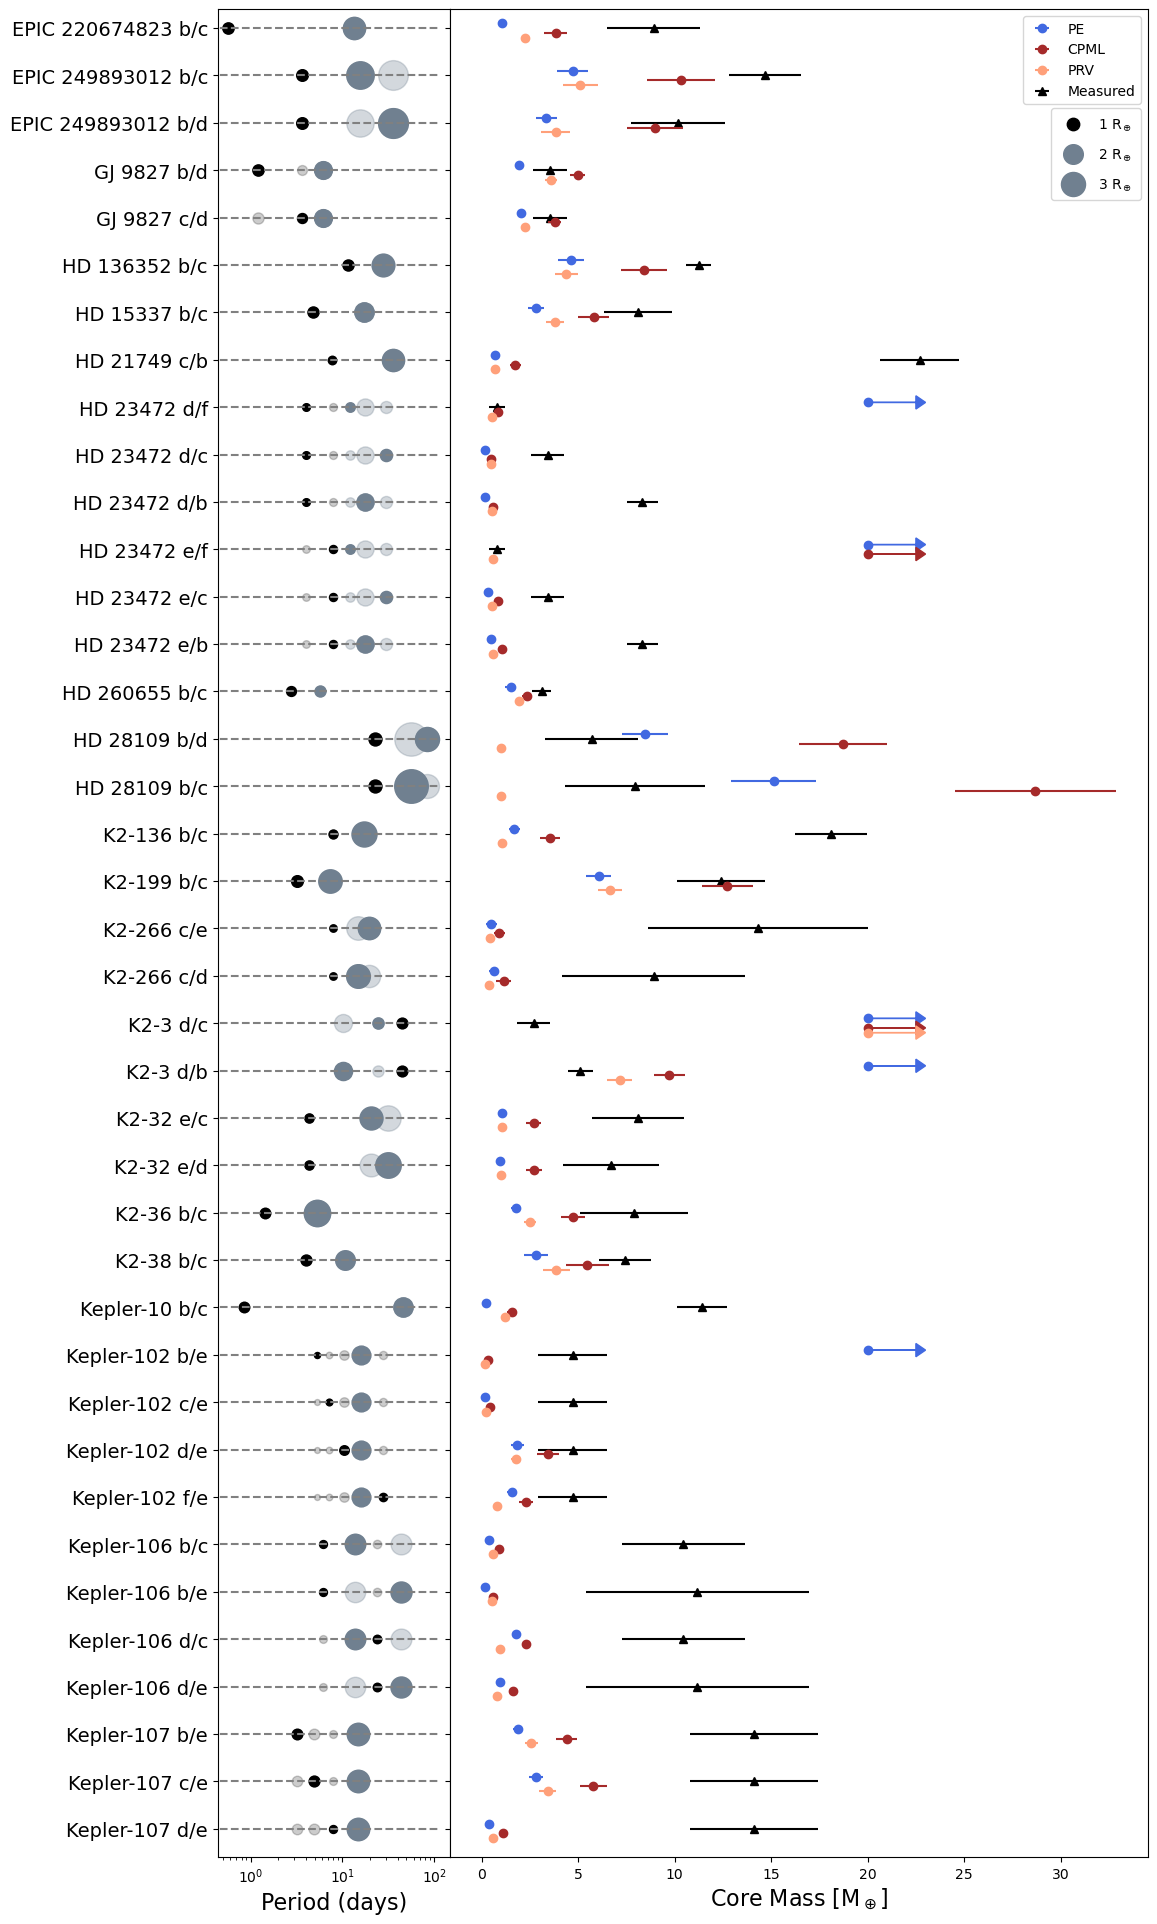

In [14]:
# Plot Figure 4
plot_figure(0,39,pdict,mechanism_dict,system_dict,save='../figures/Figure 4.png',legend=True)

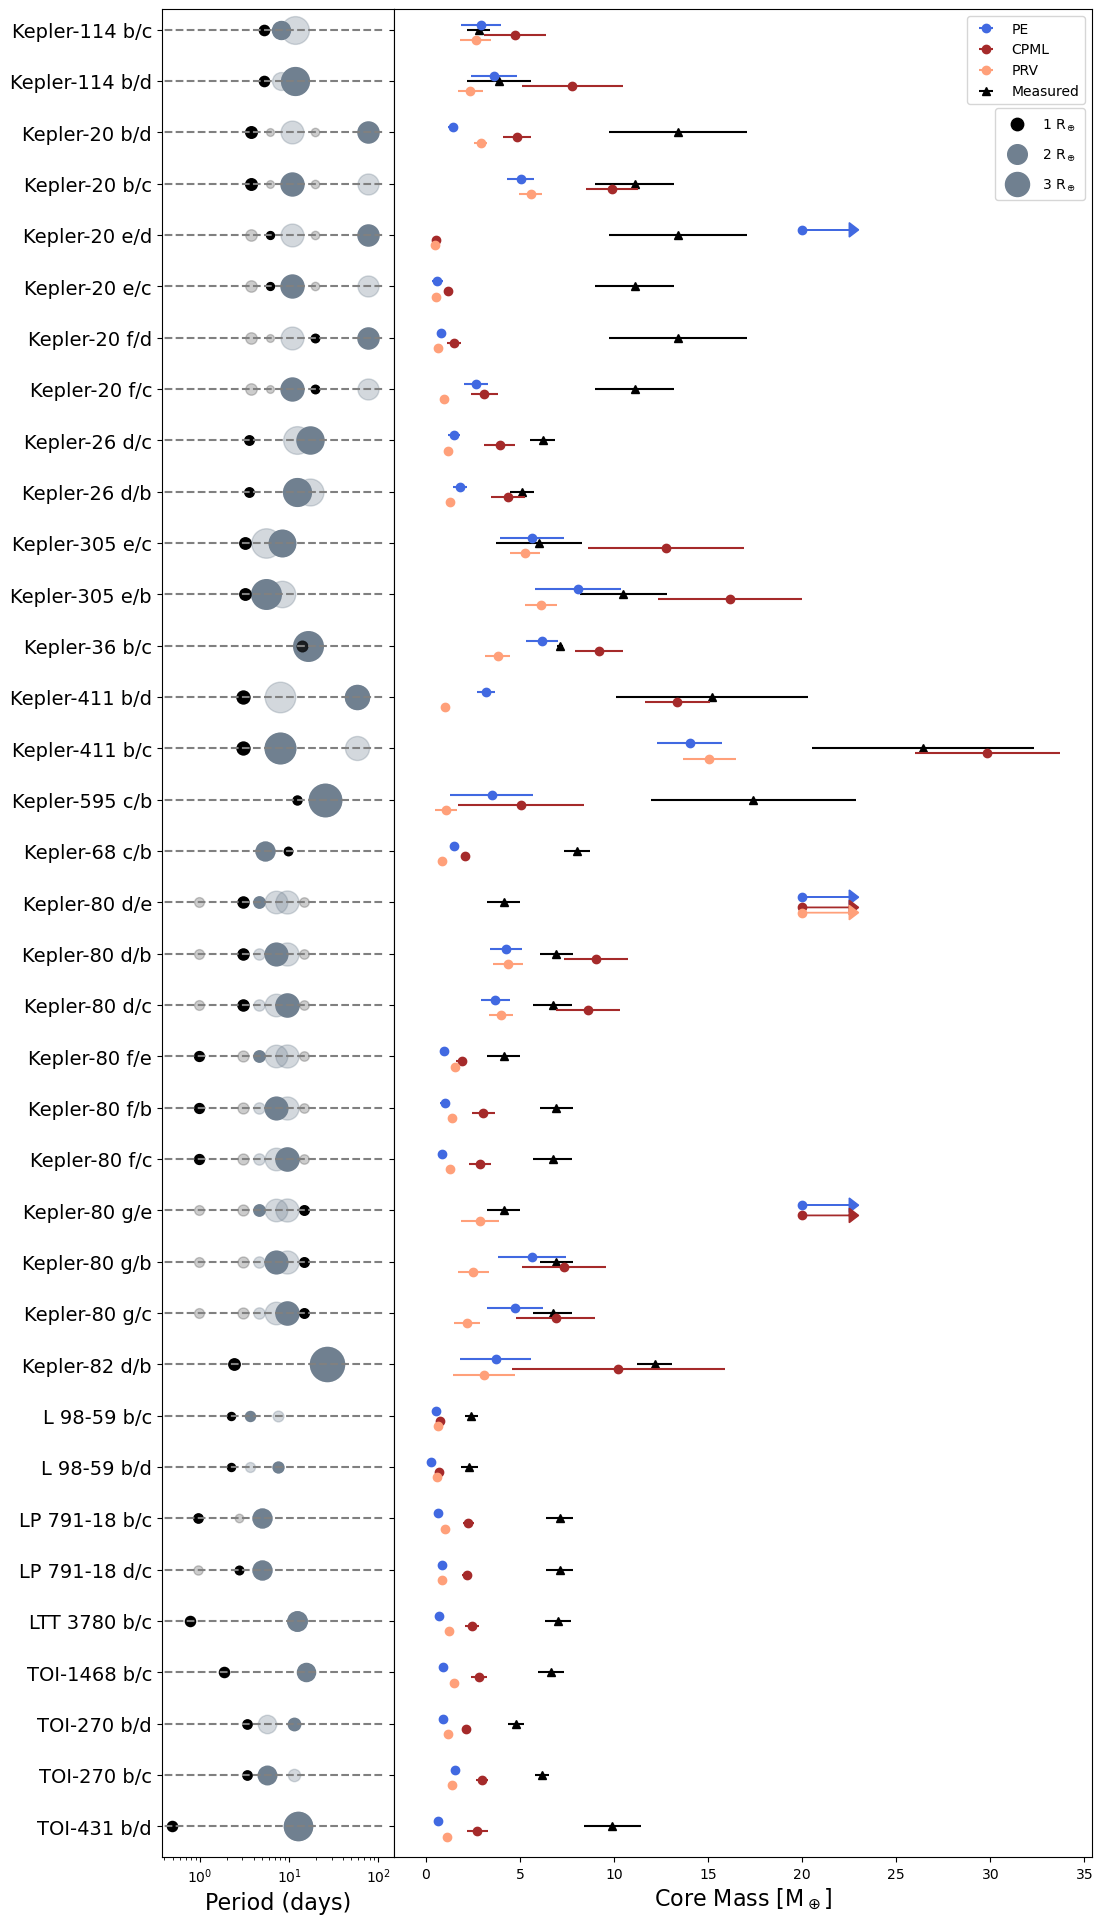

In [15]:
# Plot Figure 5
plot_figure(39,36,pdict,mechanism_dict,system_dict,save='../figures/Figure 5.png',legend=True)